## Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Fórmulas para la Pérdida Impermanente

### Fórmulas para las Pérdidas Impermanentes sin fees

Definimos las funciones de Impermanent Loss como % y en USD, en términos de $R=\frac{P}{P_0}$ y de $P$, dadas por

\begin{align*}
  IL_{\%}(R) &= \frac{2\sqrt{R}}{R+1} -1 \Rightarrow IL_{USD}(R) = IL_{\%}(R)*V_{Hold};\\
  IL_{\%}(P) &= 2\sqrt{P_0}\frac{\sqrt{P}}{P+P_0}-1 \Rightarrow IL_{USD}(P) = IL_{\%}(P)*V_{Hold};\\ 
\end{align*}

Hay otra escritura posible para $IL_{USD}(P)$ que sale usando

\begin{align*}
  V_P &= 2\sqrt{kP} = 2\sqrt{kP_0}\sqrt{\frac{P}{P_0}} = V_P^0\sqrt{\frac{P}{P_0}},\\
  V_H &= \sqrt{kP_0}\left(\frac{P}{P_0}+1\right) = 2\sqrt{kP_0}\frac{1}{2}\left(\frac{P}{P_0}+1\right)=\frac{V_H^0}{2}\left(\frac{P}{P_0}+1\right).
\end{align*}

Nos queda entonces

$$IL_{USD}(P) = V_P - V_H = V_H^0\left(\sqrt{\frac{P}{P_0}}-\frac{1}{2}-\frac{P}{2P_0}\right).$$

In [2]:
def IL_R(R):
  return 2 * R**(1/2)/(R+1)-1
def IL_P(P):
  # return IL_R(P/P_entry)
  return 2 * (P_entry)**(1/2) * P**(1/2)/(P+P_entry)-1
def IL_R_in_usd(R):
  P = R * P_entry
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * P
  return IL_R(R) * V_hold
def IL_P_in_usd(P):
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * P
  # V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * P_entry
  # return IL_R_in_usd(P/P_entry)
  return IL_P(P) * V_hold
  # return V_hold_0 * ((P/P_entry)**(1/2) - 1/2 - P/(2*P_entry))

Podemos entonces calcular la derivada de IL

\begin{align*}
  \frac{\partial}{\partial R}IL_{\%}(R) &= \frac{1-R}{\sqrt{R}(R+1)^2}; \
  \frac{\partial}{\partial P}IL_{\%}(P) = \sqrt{P_0}\frac{P_0-P}{\sqrt{P}(P+P_0)^2} \\ 
  \Rightarrow \frac{\partial}{\partial P}IL_{USD}(P) &= \frac{\partial}{\partial P}IL_{\%}(P) * V_{Hold} + IL_{\%}(P) * \frac{\partial}{\partial P}V_{Hold}\\
  &= \frac{\partial}{\partial P}IL_{\%}(P) * V_{Hold} + IL_{\%}(P) * b,
\end{align*}
donde en la última identidad usamod $V_{Hold} = tenencias\_inicial[0] + tenencias\_inicial[1] * P =: a + b*P$.

Equivalentemente, si usamos $$IL_{USD}(P) = V_P - V_H = V_H^0\left(\sqrt{\frac{P}{P_0}}-\frac{1}{2}-\frac{P}{2P_0}\right),$$
nos queda
$$\frac{\partial}{\partial P}IL_{USD}(P) = \frac{V^0_H}{2P_0}\left(\sqrt{\frac{P_0}{P}}-1\right).$$

In [3]:
#
def IL_derivada_R(R):
  return (1-R) / (R**(1/2)*(R+1)**2)
def IL_derivada_P(P):
  return IL_derivada_R(P/P_entry) / P_entry
  # return (P_entry)**(1/2)*(P_entry-P)/(P**(1/2)*(P+P_entry)**2)
def IL_derivada_P_in_usd(P):
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * P
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * P_entry
  return IL_derivada_P(P) * V_hold + IL_P(P) * tenencias_inicial[1]
  # return V_hold_0/(2*P_entry) * ((P_entry/P)**(1/2) - 1)

### Fórmulas con fees

Agregamos también las fórmulas incorporando fees. Sean $fee=\tau$, $\phi = 1-\tau$, $P:=p^{bid^1}$ y $P_0:=p^{bid^0}$. Sabiendo que $p^b = \phi P_{Y|X} = \phi \frac{y}{x}$, $R=\frac{P_{Y|X}}{P^0_{Y|X}}=\frac{p^b}{p^b_0}$ y que $V_{Hold} = a+b*p^b$, tenemos

\begin{align*}
  IL^{fee}_{\%}(R) &= \sqrt{R}\frac{1+\phi}{\phi R+1} -1 \Rightarrow \frac{\partial}{\partial R}IL^{fee}_{\%}(R) = \frac{1+\phi}{(1+\phi R)^2}\frac{1-\phi R}{2\sqrt{R}};\\
  IL^{fee}_{\%}(P) &= \sqrt{PP_0}\frac{1+\phi}{P_0+\phi P}-1 \Rightarrow \frac{\partial}{\partial P} IL^{fee}_{\%}(P) = \frac{1+\phi}{2}\sqrt{\frac{P_0}{P}}\frac{P_0-\phi P}{(P_0+\phi P)^2};\\ 
  IL^{fee}_{USD}(P) &= IL^{fee}_{\%}(P)*V_{Hold} \text{ una forma} \\
  &= \frac{V_H^0}{2}\left(\sqrt{\frac{P}{P_0}}\frac{1+\phi}{\phi}-\frac{P_0+\phi P}{P_0\sqrt{\phi}}\right) \text{ otra forma} \Rightarrow \frac{\partial}{\partial P} IL^{fee}_{USD}(P) = \frac{V_H^0}{2P_0}\left(\frac{1}{2}\sqrt{\frac{P_0}{P}}\frac{1+\phi}{\phi}-\sqrt{\phi}\right).
\end{align*}

In [4]:
def IL_R_fee(R,fee):
  phi = 1-fee
  return R**(1/2)*(1+phi)/(1+R*phi)-1
def IL_P_fee(P,fee):
  phi = 1-fee
  return IL_R_fee(P/P_entry,fee)
  # return (P*P_entry)**(1/2)*(1+phi)/(P_entry+phi*P)-1
def IL_P_in_usd_fee(P,fee):
  phi = 1-fee
  # P = R * P_entry
  p_bid = P * phi
  p_bid_entry = P_entry * phi
  # p_bid_entry = P_entry * phi
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * p_bid
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * p_bid_entry
  return V_hold_0/2 * ( (p_bid/p_bid_entry)**(1/2) * (1+phi)/phi - (p_bid_entry + phi*p_bid) / (p_bid_entry*phi**(1/2)) )
  # return IL_R_in_usd_fee(P/P_entry,fee)
#
def IL_derivada_R_fee(R, fee):
  phi = 1-fee
  return (1+phi)/(1+phi*R)**2 * (1-phi*R)/(2*R**(1/2))
def IL_derivada_P_fee(P,fee):
  phi = 1-fee
  p_bid_entry = P_entry * phi
  p_bid = P *  phi
  return IL_derivada_R_fee(P/P_entry, fee) / p_bid_entry
  # return (1+phi)/2 * (p_bid_entry/p_bid)**(1/2) * (p_bid_entry-phi*p_bid)/(p_bid_entry+phi*p_bid)**2
def IL_derivada_P_in_usd_fee(P,fee):
  phi = 1-fee
  p_bid = P * phi
  p_bid_entry = P_entry * phi
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * p_bid
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * p_bid_entry
  return IL_derivada_P_fee(P,fee) * V_hold + IL_P_fee(P, fee) * tenencias_inicial[1] 
  # return V_hold_0/(2*p_bid_entry) * ( 1/2*(p_bid_entry/p_bid)**(1/2) * (1+phi)/phi - phi**(1/2) )

### Probando los gráficos

In [5]:
R_minus = np.arange(0.01, 1, 0.01)
R_plus = np.arange(1, 10, 0.01)

In [6]:
balance_usdc = 40000
balance_eth = 100
P_entry = balance_usdc / balance_eth

In [48]:
#fig, axs = plt.subplots(1,1,figsize = (20,7))
# axs.plot(R_minus, IL_R(R_minus), c='red')
# axs.plot(R_plus, IL_R(R_plus), c='blue')
# axs.plot(R_minus*P_entry, IL_P(R_minus*P_entry), c='red')
# axs.plot(R_plus*P_entry, IL_P(R_plus*P_entry), c='blue')
# axs.plot(R_minus, IL_R_in_usd(R_minus), c='red')
# axs.plot(R_plus, IL_R_in_usd(R_plus), c='blue')
# axs.plot(R_minus*P_entry, IL_P_in_usd(R_minus*P_entry), c='red')
# axs.plot(R_plus*P_entry, IL_P_in_usd(R_plus*P_entry), c='blue')
# with fees
# fee = 0.00075
# axs.plot(R_minus, IL_R_fee(R_minus, fee), c='red')
# axs.plot(R_plus, IL_R_fee(R_plus, fee), c='blue')
# axs.plot(R_minus*P_entry, IL_P_fee(R_minus*P_entry, fee), c='red')
# axs.plot(R_plus*P_entry, IL_P_fee(R_plus*P_entry, fee), c='blue')
# axs.plot(R_minus*P_entry, IL_P_in_usd_fee(R_minus*P_entry, fee), c='red')
# axs.plot(R_plus*P_entry, IL_P_in_usd_fee(R_plus*P_entry, fee), c='blue')

IndentationError: unexpected indent (Temp/ipykernel_24248/268853344.py, line 6)

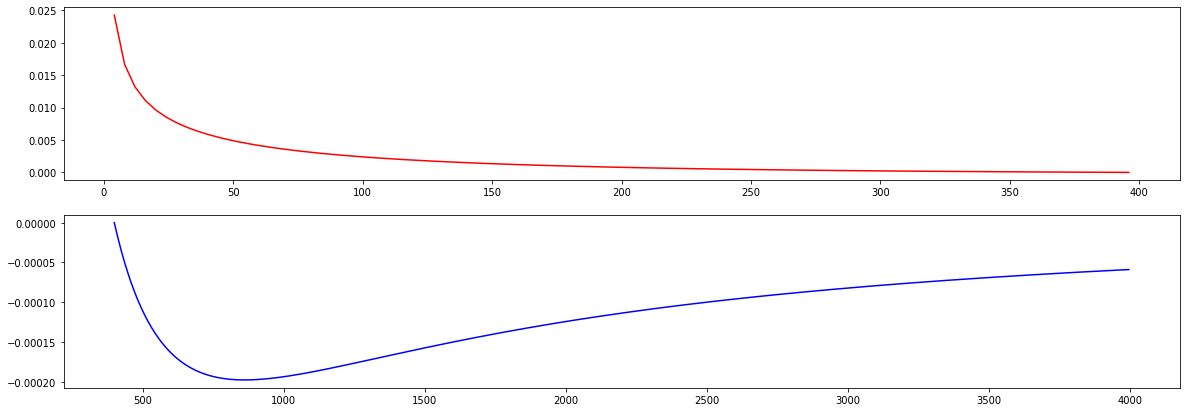

In [50]:
fig, axs = plt.subplots(2,1,figsize = (20,7))
# axs[0].plot(R_minus, IL_derivada_R(R_minus), c='red')
# axs[1].plot(R_plus, IL_derivada_R(R_plus), c='blue')
# axs[0].plot(R_minus*P_entry, IL_derivada_P(R_minus*P_entry), c='red')
# axs[1].plot(R_plus*P_entry, IL_derivada_P(R_plus*P_entry), c='blue')
# axs[0].plot(R_minus*P_entry, IL_derivada_P_in_usd(R_minus*P_entry), c='red')
# axs[1].plot(R_plus*P_entry, IL_derivada_P_in_usd(R_plus*P_entry), c='blue')
# with fees
# fee = 0.00075
# axs[0].plot(R_minus, IL_derivada_R_fee(R_minus, fee), c='red')
# axs[1].plot(R_plus, IL_derivada_R_fee(R_plus, fee), c='blue')
# axs[0].plot(R_minus*P_entry, IL_derivada_P_fee(R_minus*P_entry, fee), c='red')
# axs[1].plot(R_plus*P_entry, IL_derivada_P_fee(R_plus*P_entry, fee), c='blue')
# axs[0].plot(R_minus*P_entry, IL_derivada_P_in_usd_fee(R_minus*P_entry, fee), c='red')
# axs[1].plot(R_plus*P_entry, IL_derivada_P_in_usd_fee(R_plus*P_entry, fee), c='blue')

El siguiente gráfico muestra la fórmula de la pérdida impermanente en términos de la relación de precios entre cuando se proporcionó liquidez y el momento actual

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Price change,-100.0%,-80.0%,-60.0%,-40.0%,-20.0%,-0.0%,20.0%,40.0%,60.0%,80.0%,100.0%,120.0%,140.0%,160.0%,180.0%
R,0.0%,20.0%,40.0%,60.0%,80.0%,100.0%,120.0%,140.0%,160.0%,180.0%,200.0%,220.0%,240.0%,260.0%,280.0%
IL ratio,100.0%,30.0%,10.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,10.0%,10.0%,10.0%,10.0%,10.0%


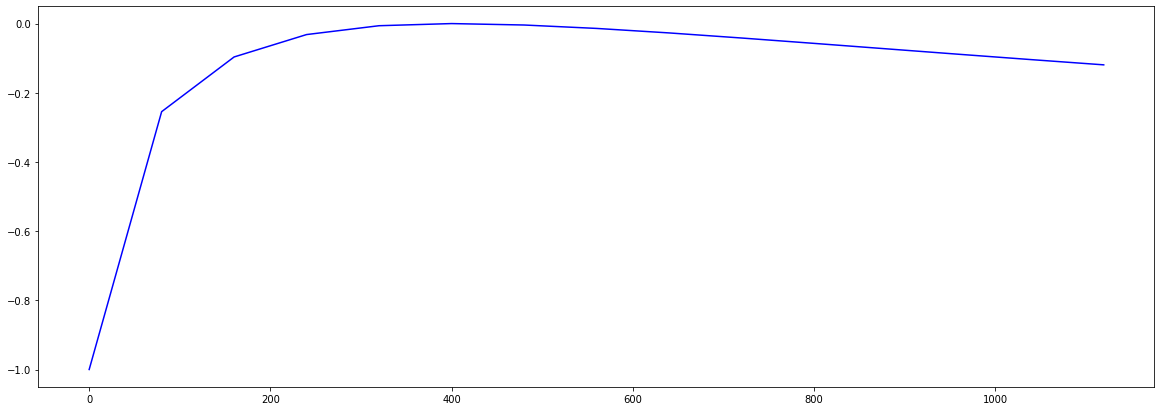

In [7]:

balance_usdc = 40000
balance_eth = 100
P_eth_0 = balance_usdc / balance_eth
price_change = np.arange(-1, 2, 0.2)
fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(P_eth_0*(1+price_change), IL_R(1+price_change), c = 'blue')

pd.DataFrame([[str(round(i*100,3))+'%',
               str(round((i+1)*100,3))+'%',
               str(round(abs(IL_R(i+1)),1)*100)+'%'] for i in price_change],
             columns = ['Price change', 'R', 'IL ratio']).T


La pérdida impermanente ocurre sin importar en qué dirección cambie el precio: los casos en que el precio cae pueden ser más peligrosos que cuando el precio aumenta.

## Estrategias de hedging  con opciones

Los futuros son un instrumento tipico para hedgearse contra movimientos de precio, el problema es que ofrecen protección lineal pero la IL tiene un comportamiento no lineal bidireccional.

Es por eso que las opciones son un mejor instrumento, como veremos a continuación.

El problema con las opciones es que tienen un costo y la estrategia puede dejar de ser rentable si no se estudia cuidadosamente la cantidad de opciones y el rebalanceo necesarios.


Con una estrategia conocida como Long Strangle, que consiste de holdear un call y un put sobre el mismo activo pero con diferentes strike prices, podemos hedgear la IL hasta cierto punto.


##### Más funciones:

La siguiente función tiene como inputs precio de ETHE $P$, vectores de strikes $K_\text{call}$, $K_\text{put}$  y de primas $d_\text{call}$, $d_\text{put}$  asociados a un conjunto de calls y puts y tiene como output el pnL de considerar la combinacion de estas opciones cuando el precio del subyacente es $P$

In [8]:
def option_combination(P,K_call, K_put,d_call,d_put):
   call=0
   put=0
   for i in range(len(K_call)):
         call = call + max(P-K_call[i],0)
   for i in range(len(K_put)): 
         put = put + max(K_put[i]-P,0)  
   return call+put-sum (d_call)-sum(d_put)


A continuación definimos la función de pérdida impermanente en USD considerando como  inputs el precio actual, el precio de entrada del pool  y los balances iniciales del provedor de liquidez,  usamos la función $IL_R$ definida antes. 

In [9]:
def IL_P_usd(p,x_0,y_0, p_entry):
    V_hold = x_0 + y_0 * p
    return V_hold * (IL_R(p/p_entry))


### Idea 1: Hedging con un conjunto de Calls y Puts

Un provedor de liquidez ingresa al pool depositando $x_0$  cantidad de USDC e $y_0$ cantidad de ETHE tal que $x_0 y_0=k$

Sea  $r_p$ la tasa de retorno mensual del pool

Consideramos una estrategia del tipo Strangle, la misma consiste en comprar $q_c$ unidades de opciones calls con strike $K_c$ ETH  y $q_p$ puts con strike $K_p$ ETH, llamemos $d_1$ y $d_2$ las primas respectivas.

El PnL a tiempo T será  $$f_T=(P_T-K_c)^+ +(K_p-P_T)^+ - D$$  
donde $D:=d_1+d_2$.

A tiempo $T$ tenemos cierta "perdida impermanente" por depositar los tokens en el pool

$$IL(P_T)= V_P - V_H = V_H^0\left(\sqrt{\frac{P}{P_0}}-\frac{1}{2}-\frac{P}{2P_0}\right),$$
donde $V_H^0=x_0+P_0 y_0$, $P_0$ precio de ETH en el momento que se ingreso en el pool.

Por lo tanto, si  consideremos la estrategia Strangle para cubrirnos de las perdidas impermanente, tendríamos el siguiente PnL de la estrategía:

$$ f_T^{pool+s}= r_p (x_0+y_0 P_0)+ f_T+IL(P_T)  $$ 

Para no estar en perdida buscamos que sea mayor o igual que cero.









#### Ejemplo


Supongamos que tenemos un pool wETH-USDC con $40000$ USDC y $100$ wETH por un valor total de $80000$, es decir, $P_{ETH} = 400$ USDC. La constante $k = 40000*100=4000000$.



Probemos entonces con un conjunto de calls y puts, con $\pm 30\%$ del spot como strike price, y mantenemos la misma cantidad de opciones como tenencias del token dentro del pool.

Es decir, el LP compra 100 unidades de call con strike price $400*1.3 = 500$ USDC y 100 unidades de puts con strike price $400*0.7 = 280$ USDC con expiration a 30 dias.


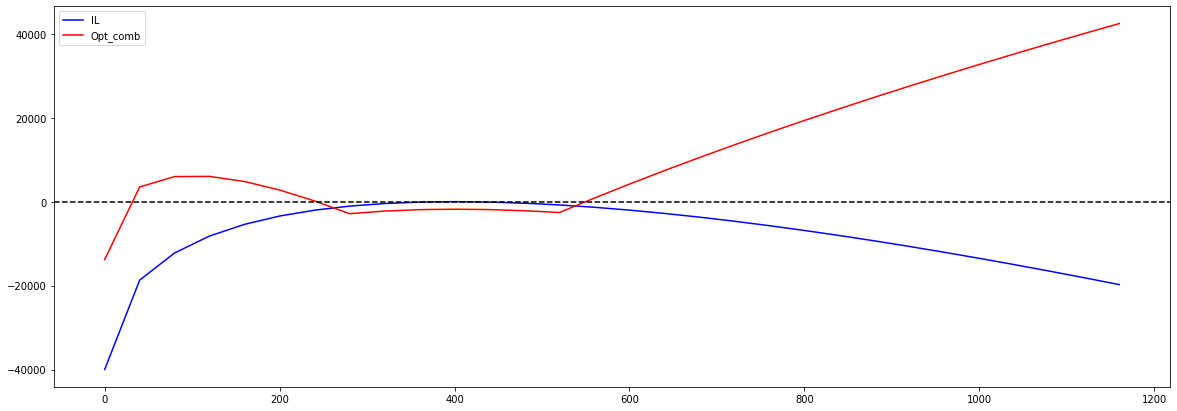

In [10]:
balance_usdc = 40000 #x_0
balance_eth = 100 #y_0

P_eth_0 = balance_usdc / balance_eth #P_0
V_h_0= balance_usdc+balance_eth*P_eth_0 # valor en dólares de las tenencias iniciales

price_change = np.arange(-1, 2, 0.1)


r_p = 0.02  # radio mensual por proveer liquidez
P = P_eth_0*(1+ price_change)

ret_mens_pool=r_p* V_h_0 # ¿sobre las tenencias inicial?

  
K_call =  520*np.ones(100)
K_put =  280*np.ones(100)
d_call = 12*np.ones(100)
d_put = 6*np.ones(100)
opt_stg = [option_combination(p,K_call,K_put,d_call,d_put) for p in P] 


IL_sin_hedg_usd = [IL_P_usd(p, balance_usdc, balance_eth, P_eth_0) for p in P]
IL_con_hedg_usd = r_p*np.ones(len(P)) + IL_sin_hedg_usd + opt_stg


fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(P, IL_sin_hedg_usd, c = 'blue', label = 'IL')

axs.plot(P, IL_con_hedg_usd, c = 'red', label = 'Opt_comb')
axs.legend()
axs.axhline(y = 0, color = 'black', linestyle = '--')

Veamos el gráfico en función de la razón de cambio de precios al momento de entrada y salida del pool

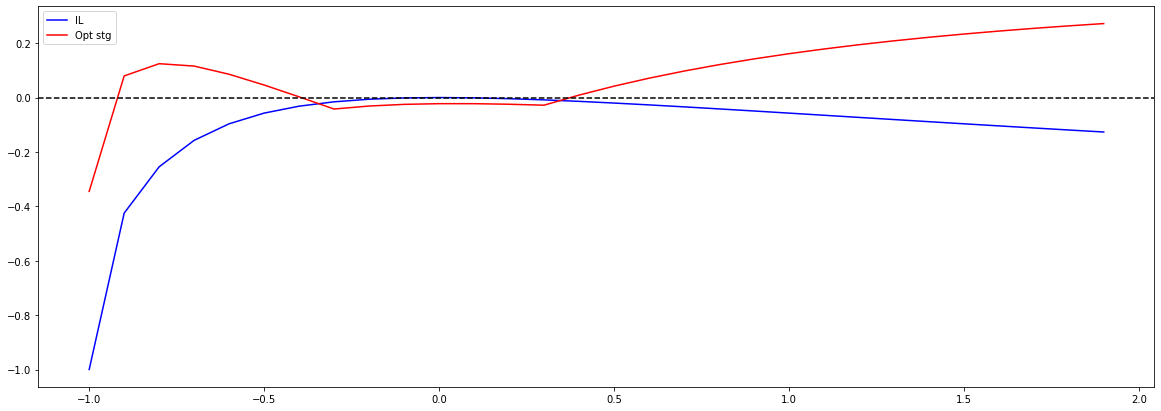

In [24]:

V_hold = balance_usdc + balance_eth * P
V_pool = IL_R(1+price_change) * V_hold
IL_sin_hedg = (V_pool - V_hold) / V_hold
#
IL_con_hedg = (r_p*np.ones(len(P))+V_pool + opt_stg - V_hold) / V_hold
#
fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(price_change, IL_sin_hedg+1, c = 'blue', label = 'IL')
axs.plot(price_change, IL_con_hedg+1, c = 'red', label = 'Opt stg')
axs.legend()
axs.axhline(y = 0, color = 'black', linestyle = '--')

De los  gráficos anteriores se observa que:

1. La IL se ha equilibrado totalmente cuando el precio aumenta por encima del 40%. Además, la opción de compra termina generando ganancias y es más que suficiente para cubrirse contra la IL.

2. En el ala izquierda, la estrategia de cobertura con los puts va bien y termina con ganancias. Sin embargo, debido al caso de que la pérdida se acelere a medida que el precio se derrumba aún más, esta opción de venta no será suficiente para compensar la pérdida, y el rendimiento finalmente termina siendo negativo.

3. El costo fijo de esta estrategia de cobertura es alto. Según el cálculo, el coste fijo de las primas de las opciones es del 2,25% de la inversión inicial, y es una estrategia de protección a 30 días.  El costo puede alcanzar el 27% anual si la estrategia se repite todos los meses. El costo es alto.

Se pueden hacer algunos ajustes para obtener un mejor resultado de cobertura.

1. Los índices de IL cuando el precio de ETH sube y baja no son simétricos;

2. Pueden usarse múltiples combinaciones de call y put para la cobertura al alza y a la baja;

3. La cantidad de opciones se puede ajustar para hacer que la línea roja se eleve menos para adaptarse a diferentes estrategias;

4. No es necesario que el rango efectivo de cobertura cubra todo el movimiento del precio de -100% a +500%.‍

### Idea 2: Hedging con combinaciones de Calls y Puts


Debido a las características lineales en el comportamiento de las ganancias frente a los cambios de precios, cuando las opciones están in-the-money, es imposible cubrirse perfectamente contra la IL (que tiene una naturaleza convexa)  con solo un tipo de opciones de compra y venta. Sin embargo, con combinaciones de múltiples opciones de compra y venta, podemos encontrar una manera de compensar la IL con mayor efectividad mientras ajustamos los pesos de diferentes opciones con varios precios de ejercicios

### Hedging con multiples opciones

1. Rango de cobertura de precios: de -60% a +100%;

2. Período de cobertura: 30 días;

3. Opciones de compra: 6 llamadas ETH con precio de ejercicio $480 (+20%), 8 llamadas ETH con precio de ejercicio $520 (+30%), 10 llamadas ETH con precio de ejercicio $560 (+40%);

4. Opciones de venta: 8 opciones de venta de ETH con precio de ejercicio de $360 (-10%), 10 opciones de venta de ETH con precio de ejercicio de $320 (-20%), 15 opciones de venta de ETH con precio de ejercicio de $280 (-30%), 5 opciones de venta de ETH con precio de ejercicio $240 (-40%).



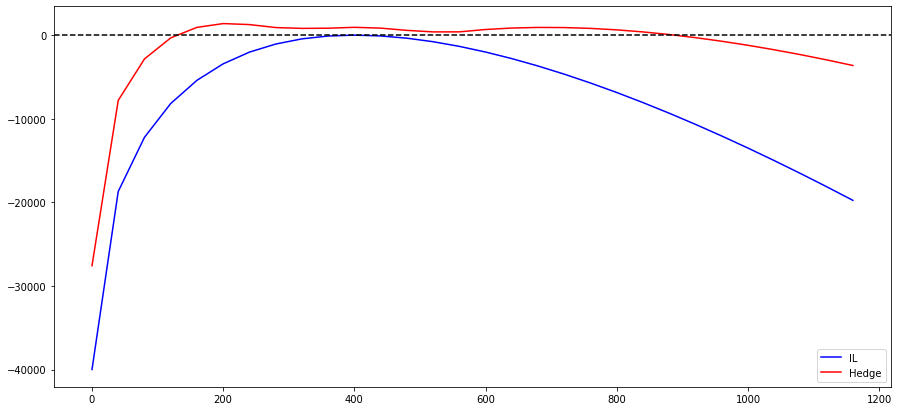

In [13]:
### Datos de la tenencia en el pool
balance_usdc = 40000 #x_0
balance_eth = 100 #y_0

P_eth_0 = balance_usdc / balance_eth #P_0
V_h_0= balance_usdc+balance_eth*P_eth_0 # valor en dólares de las tenencias iniciales


r_p = 0.02  # radio mensual por proveer liquidez
ret_mens_pool=r_p* V_h_0 # ¿sobre las tenencias inicial?


# Datos de la estrategía con opciones
K_call = np.concatenate((480*np.ones(6), 520*np.ones(8), 560*np.ones(10)))
K_put = np.concatenate((360*np.ones(8), 320*np.ones(10), 280*np.ones(15), 240*np.ones(5)))
d_call = np.concatenate((16*np.ones(6), 16*np.ones(8), 10.5*np.ones(10)))
d_put = np.concatenate((18*np.ones(8), 9*np.ones(10), 6*np.ones(15), 2.4*np.ones(5)))


### Cambios de precios
price_change = np.arange(-1, 2, 0.1)
P = P_eth_0*(1+ price_change)

## 
opt_comb = [option_combination(p,K_call,K_put,d_call,d_put) for p in P]
IL_sin_hedg_usd = [IL_P_usd(p, balance_usdc, balance_eth, P_eth_0) for p in P]
IL_con_hedg_usd = ret_mens_pool*np.ones(len(P)) + IL_sin_hedg_usd + opt_comb

# Plots
fig, axs = plt.subplots(1,1,figsize = (15,7))
axs.plot(P, IL_sin_hedg_usd, c = 'blue', label = 'IL')

axs.plot(P, IL_con_hedg_usd, c = 'red', label = 'Hedge')
axs.legend()
axs.axhline(y = 0, color = 'black', linestyle = '--')

Veamos el gráfico en función de la razón de cambio de precios al momento de entrada y salida del pool

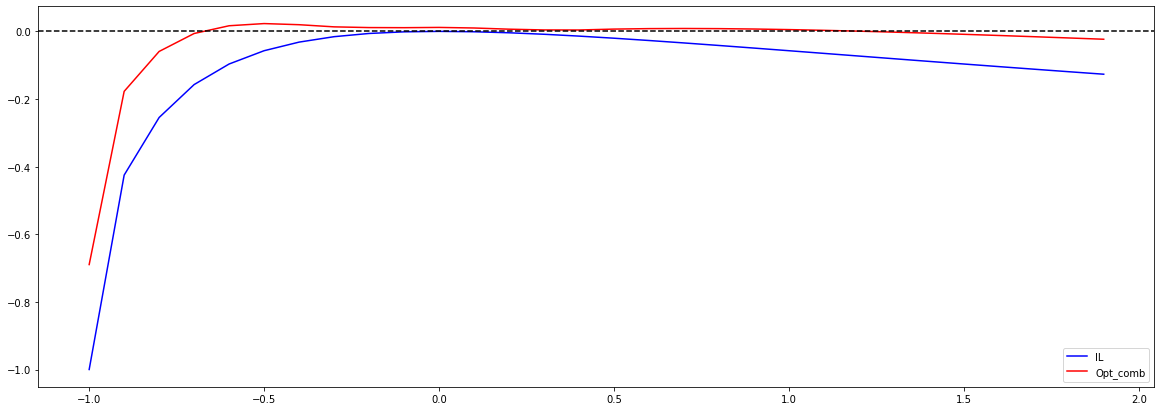

In [36]:

V_hold = balance_usdc + balance_eth * P
V_pool = IL_R(1+price_change) * V_hold
IL_sin_hedge = (V_pool - V_hold) / V_hold
#
opt_comb = [option_combination(p,K_call,K_put,d_call,d_put) for p in P]
IL_con_hedge = (ret_mens_pool*np.ones(len(P))+V_pool + opt_comb - V_hold) / V_hold
#
fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(price_change, IL_sin_hedge+1, c = 'blue', label = 'IL')

axs.plot(price_change, IL_con_hedge+1, c = 'red', label = 'Opt_comb')
axs.legend()
axs.axhline(y = 0, color = 'black', linestyle = '--')

### Hedging IL con multiples opciones-conservativo

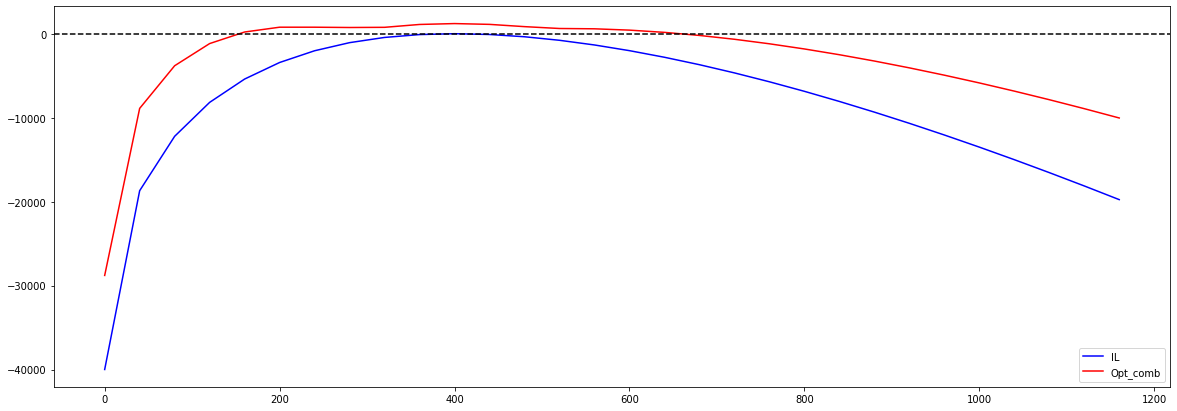

In [39]:
### Datos de la tenencia en el pool
balance_usdc = 40000 #x_0
balance_eth = 100 #y_0

P_eth_0 = balance_usdc / balance_eth #P_0
V_h_0= balance_usdc+balance_eth*P_eth_0 # valor en dólares de las tenencias iniciales


r_p = 0.02  # radio mensual por proveer liquidez
ret_mens_pool=r_p* V_h_0 # ¿sobre las tenencias inicial?


# Datos de la estrategía con opciones
K_call = np.concatenate((480*np.ones(5), 520*np.ones(8)))
K_put = np.concatenate((320*np.ones(15), 280*np.ones(10), 240*np.ones(10)))
d_call = np.concatenate((16*np.ones(5), 12*np.ones(8)))
d_put = np.concatenate((9*np.ones(15), 6*np.ones(10), 2.4*np.ones(10)))


### Cambios de precios
price_change = np.arange(-1, 2, 0.1)
P = P_eth_0*(1+ price_change)

## 
opt_comb = [option_combination(p,K_call,K_put,d_call,d_put) for p in P]
IL_sin_hedg_usd = [IL_P_usd(p, balance_usdc, balance_eth, P_eth_0) for p in P]
IL_con_hedg_usd = ret_mens_pool*np.ones(len(P)) + IL_sin_hedg_usd + opt_comb

# Plots
fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(P, IL_sin_hedg_usd, c = 'blue', label = 'IL')

axs.plot(P, IL_con_hedg_usd, c = 'red', label = 'Opt_comb')
axs.legend()
axs.axhline(y = 0, color = 'black', linestyle = '--')

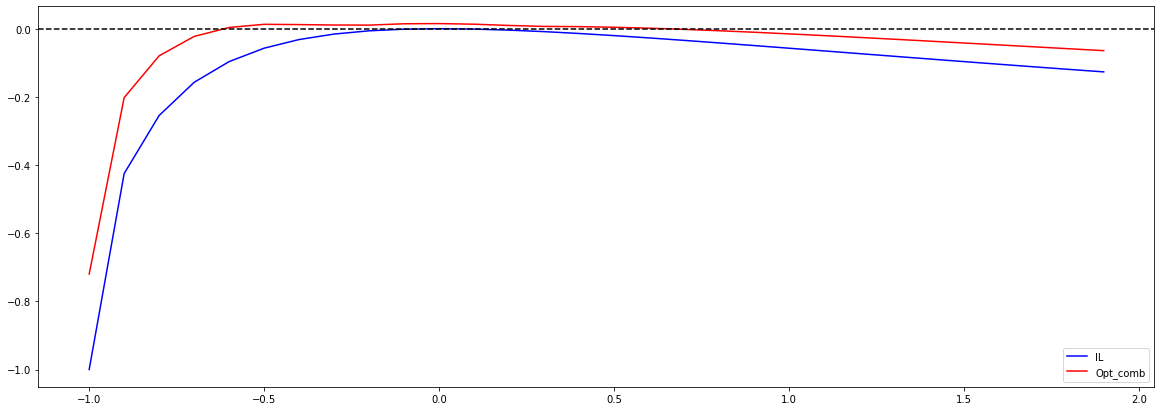

In [40]:

V_hold = balance_usdc + balance_eth * P
V_pool = IL_R(1+price_change) * V_hold
IL_sin_hedge = (V_pool - V_hold) / V_hold
#
opt_comb = [option_combination(p,K_call,K_put,d_call,d_put) for p in P]
IL_con_hedge = (ret_mens_pool*np.ones(len(P))+V_pool + opt_comb - V_hold) / V_hold
#
fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(price_change, IL_sin_hedge+1, c = 'blue', label = 'IL')

axs.plot(price_change, IL_con_hedge+1, c = 'red', label = 'Opt_comb')
axs.legend()
axs.axhline(y = 0, color = 'black', linestyle = '--')

### Hedging IL con multiples opciones- agresivo 

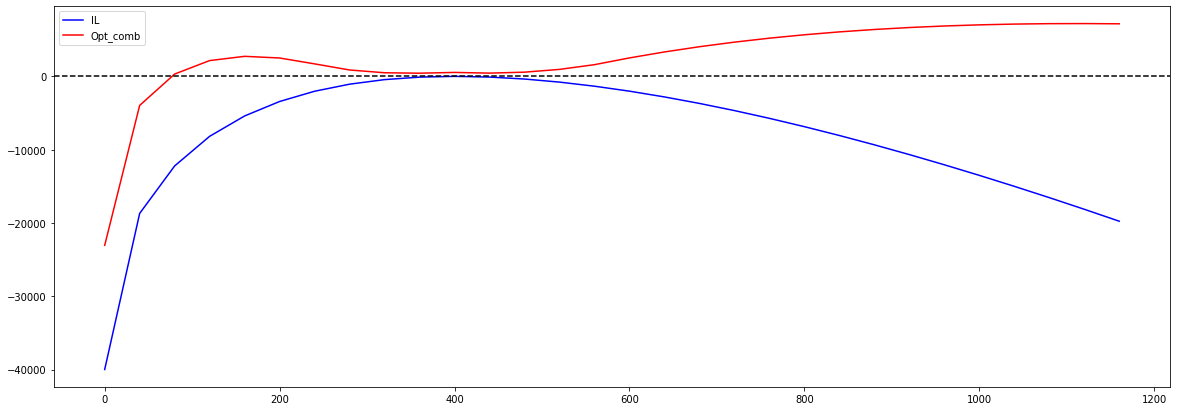

In [53]:
### Datos de la tenencia en el pool
balance_usdc = 40000 #x_0
balance_eth = 100 #y_0

P_eth_0 = balance_usdc / balance_eth #P_0
V_h_0= balance_usdc+balance_eth*P_eth_0 # valor en dólares de las tenencias iniciales


r_p = 0.02  # radio mensual por proveer liquidez
ret_mens_pool=r_p* V_h_0 # ¿sobre las tenencias inicial?


# Datos de la estrategía con opciones
K_call = np.concatenate((440*np.ones(10), 480*np.ones(10),520*np.ones(10), 560*np.ones(10)))
K_put = np.concatenate((360*np.ones(10), 320*np.ones(15), 280*np.ones(20), 240*np.ones(10)))
d_call = np.concatenate((22*np.ones(10), 16*np.ones(10), 12*np.ones(10), 10.5*np.ones(10)))
d_put = np.concatenate((18*np.ones(10), 9*np.ones(15), 6*np.ones(20), 2.4*np.ones(10)))


### Cambios de precios
price_change = np.arange(-1, 2, 0.1)
P = P_eth_0*(1+ price_change)

## 
opt_comb = [option_combination(p,K_call,K_put,d_call,d_put) for p in P]
IL_sin_hedg_usd = [IL_P_usd(p, balance_usdc, balance_eth, P_eth_0) for p in P]
IL_con_hedg_usd = ret_mens_pool*np.ones(len(P)) + IL_sin_hedg_usd + opt_comb

# Plots
fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(P, IL_sin_hedg_usd, c = 'blue', label = 'IL')

axs.plot(P, IL_con_hedg_usd, c = 'red', label = 'Opt_comb')
axs.legend()
axs.axhline(y = 0, color = 'black', linestyle = '--')

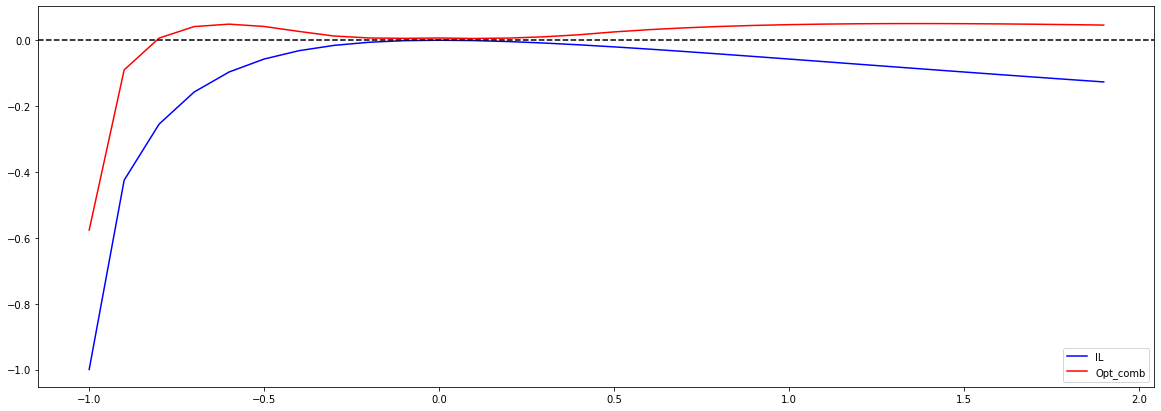

In [54]:

V_hold = balance_usdc + balance_eth * P
V_pool = IL_R(1+price_change) * V_hold
IL_sin_hedge = (V_pool - V_hold) / V_hold
#
opt_comb = [option_combination(p,K_call,K_put,d_call,d_put) for p in P]
IL_con_hedge = (ret_mens_pool*np.ones(len(P))+V_pool + opt_comb - V_hold) / V_hold
#
fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(price_change, IL_sin_hedge+1, c = 'blue', label = 'IL')

axs.plot(price_change, IL_con_hedge+1, c = 'red', label = 'Opt_comb')
axs.legend()
axs.axhline(y = 0, color = 'black', linestyle = '--')

# Traigo datos historicos de ETH

In [15]:
!pip install python-binance


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import pandas as pd
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

### API
binance_api_key = '9zFIgetckRO80d4RciWs8jc4XSwAMEnFIuwVhAoaYIstQ9RWlfqiV6zcAGu0Ta8R'    #Enter your own API-key here
binance_api_secret = 'Uu8vtNEmH1PPDPDchX51jivxBENEbNwDmDcQrnhPJBJwFcbqjnvxL2MeQJuTc4Kg' #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "10m": 10, "15m": 15, "1h": 60, "6h": 360, "12h": 720, "1d": 1440}

batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

# initial_date = '1 Jan 2017'
initial_date = '31 Mar 2021'
### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime(initial_date, '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime(initial_date, '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df


Nos quedamos con datos históricos para ETHUSDC con frecuencia de 5m.

In [17]:
# lista = ["ETHUSDC"]

# BTC ETH MATIC UNI COMP AAVE YFI CRV MKR LINK KP3R SFI SUSHI 1INCH CAKE 
symbol = "ETHUSDC"
# Frecuencia: 1m, 5m, 10m, 15m, 1h, 1d, 1m
freq = "5m"

# Descarga de datos
ETH_historico = get_all_binance(symbol, freq, save = True)

All caught up..!


In [18]:
ETH_historico

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2021-03-31 00:00:00,1841.29000000,1845.35000000,1841.12000000,1845.35000000,13.45650000,1617149099999,24811.47621960,39,4.46207000,8228.10868710,0
2021-03-31 00:05:00,1844.39000000,1847.08000000,1843.99000000,1846.29000000,54.69818000,1617149399999,100898.41600010,50,18.71127000,34521.30106140,0
2021-03-31 00:10:00,1845.54000000,1849.53000000,1845.54000000,1848.96000000,10.56434000,1617149699999,19523.84183440,31,6.35202000,11739.72432620,0
2021-03-31 00:15:00,1848.96000000,1850.35000000,1847.50000000,1847.50000000,126.93107000,1617149999999,234808.65135190,117,70.35710000,130155.06817220,0
2021-03-31 00:20:00,1848.12000000,1849.12000000,1846.00000000,1846.00000000,16.03979000,1617150299999,29631.68322550,61,3.04496000,5630.11817930,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28 12:45:00,1628.75000000,1656.78000000,1627.78000000,1641.85000000,1108.78490000,1659012599999,1821269.63737500,1408,573.17050000,941961.43116800,0
2022-07-28 12:50:00,1642.17000000,1648.98000000,1638.08000000,1643.37000000,632.88120000,1659012899999,1040827.76600800,866,328.29120000,540069.27683400,0
2022-07-28 12:55:00,1642.21000000,1642.80000000,1632.82000000,1635.29000000,334.82860000,1659013199999,548317.78677500,709,149.62610000,245067.87199100,0


In [19]:
P_ETH = ETH_historico[:2000]['close']
for i in range(len(P_ETH)):
  P_ETH[i] = float(P_ETH[i])

C:\Users\seque\AppData\Local\Temp/ipykernel_69092/2209025855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_ETH[i] = float(P_ETH[i])


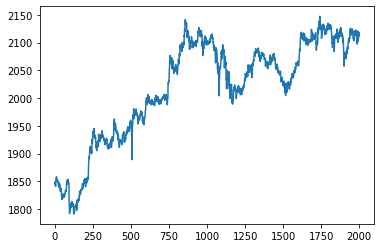

In [20]:
plt.plot(list(P_ETH))
# plt.figsize(20,7)

# Obtener cotizaciones de opciones desde Deribit

In [9]:

import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


In [10]:
%matplotlib inline

def plot_iv_surf(x,y,z,x2=None,y2=None,z2=None,label='', instrument_name="BTC"):
    fig = plt.figure(3, figsize=(10,10))
    ax=plt.axes(projection='3d')
    ax.set_title(f'{instrument_name} Implied Volatility Surface')
    ax.set_zlabel('Implied Volatility')
    plt.xlabel('Strike')
    plt.ylabel('Days To Expiration')
    ax.zaxis.set_major_formatter(FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
    if z2 is not None:
        ax.scatter3D(x2,y2,z2, c='r', s=100,label=label)
    ax.plot_surface(x, y, z, rstride=1, cstride=1,alpha=0.5)
    ax.legend()

In [11]:

def get_all_instruments():
  import urllib.request, json
  url = f"https://test.deribit.com/api/v2/public/get_instruments"
  with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
  return data

# Get a list of all active BTC options from the Deribit API.
def get_all_active_options(instrument_name="BTC"):
    import urllib.request, json
    url =  f"https://test.deribit.com/api/v2/public/get_instruments?currency={instrument_name}&kind=option&expired=false"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.DataFrame(data['result']).set_index('instrument_name')
    data['creation_date'] = pd.to_datetime(data['creation_timestamp'], unit='ms')
    data['expiration_date'] = pd.to_datetime(data['expiration_timestamp'], unit='ms')
    print(f'{data.shape[0]} active options.')
    return data

# Filter options based on data available from 'get_instruments'
def filter_options(price, active_options):
    # price is the current price of BTC
    
    #Get Put/Call information
    pc = active_options.index.str.strip().str[-1]
    
    # Set "moneyness"
    active_options['m'] = np.log(active_options['strike']/price)
    active_options.loc[pc=='P','m'] = -active_options['m']
    # Set days until expiration
    active_options['t'] = (active_options['expiration_date']-pd.Timestamp.today()).dt.days
    
    # Only include options that are less than 30% from the current price and have less than 91 days until expiration
    active_options = active_options.query('m>0 & m<.3 & t<91')
    
    print(f'{active_options.shape[0]} active options after filter.')
    return active_options

# Get Tick data for a given instrument from the Deribit API
def get_tick_data(instrument_name="BTC"):
    import urllib.request, json
    url =  f"https://test.deribit.com/api/v2/public/ticker?instrument_name={instrument_name}"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.json_normalize(data['result'])
    data.index = [instrument_name]
    return data

# Loop through all filtered options to get the current 'ticker' datas
def get_all_option_data(instrument_name="BTC"):
    option_data = get_tick_data(f'{instrument_name}-PERPETUAL')
    options = filter_options(option_data['last_price'][0], get_all_active_options(instrument_name))
    for o in options.index:
        option_data = option_data.append(get_tick_data(o))
    return option_data



In [12]:
instrument_name = "ETH" # BTC, ETH or SOL

In [13]:
option_data = get_all_option_data(instrument_name)
print(option_data)

466 active options.
87 active options after filter.


<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed fro

<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed fro

<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed fro

                        timestamp state  settlement_price  open_interest  \
ETH-PERPETUAL       1677240755739  open       1651.540000    586979191.0   
ETH-25FEB23-1300-P  1677240757751  open          0.000000            0.0   
ETH-25FEB23-1400-P  1677240757752  open          0.000000            0.0   
ETH-25FEB23-1450-P  1677240758757  open          0.000000            0.0   
ETH-25FEB23-1500-P  1677240758755  open          0.000000            0.0   
...                           ...   ...               ...            ...   
ETH-28APR23-1700-C  1677240792991  open          0.081125            3.0   
ETH-28APR23-1800-C  1677240792995  open          0.059954         2500.0   
ETH-28APR23-1900-C  1677240794002  open          0.031532            0.0   
ETH-28APR23-2000-C  1677240793998  open          0.025899            3.0   
ETH-28APR23-2200-C  1677240793998  open          0.019244         2500.0   

                    min_price  max_price  mark_price  last_price  \
ETH-PERPETUAL      

<ipython-input-11-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))


In [14]:
### Add additional metrics to data
option_data['t'] = np.nan; option_data['strike'] = np.nan; option_data['callput'] = np.nan
# Calculated days until expiration
option_data.loc[1:,'t'] = (pd.to_datetime(option_data[1:].index.map(lambda x: x.split('-')[1]))-pd.Timestamp.today()).days
# Pull strike from instrument name
option_data.loc[1:,'strike'] = option_data[1:].index.map(lambda x: x.split('-')[2]).astype(int)
# pull callput
option_data.loc[1:, 'callput'] = option_data[1:].index.map(lambda x: x.split('-')[3]).astype(str)
# Calculate "moneyness"
option_data['m'] = np.log(option_data['last_price'][0]/option_data['strike'])

<ipython-input-14-221058f4b6a2>:4: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  option_data.loc[1:,'t'] = (pd.to_datetime(option_data[1:].index.map(lambda x: x.split('-')[1]))-pd.Timestamp.today()).days
<ipython-input-14-221058f4b6a2>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  option_data.loc[1:,'strike'] = option_data[1:].index.map(lambda x: x.split('-')[2]).astype(int)
<ipython-input-14-221058f4b6a2>:8: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  option_data.loc[1:, 'callput'] = option_data[1:].index.map(lambda x: x.split('-')[3]).astype(str)


In [210]:
option_data.columns

Index(['timestamp', 'state', 'settlement_price', 'open_interest', 'min_price',
       'max_price', 'mark_price', 'last_price', 'interest_value',
       'instrument_name', 'index_price', 'funding_8h',
       'estimated_delivery_price', 'current_funding', 'best_bid_price',
       'best_bid_amount', 'best_ask_price', 'best_ask_amount',
       'stats.volume_usd', 'stats.volume', 'stats.price_change', 'stats.low',
       'stats.high', 'underlying_price', 'underlying_index', 'mark_iv',
       'interest_rate', 'bid_iv', 'ask_iv', 'greeks.vega', 'greeks.theta',
       'greeks.rho', 'greeks.gamma', 'greeks.delta', 't', 'strike', 'callput',
       'm'],
      dtype='object')

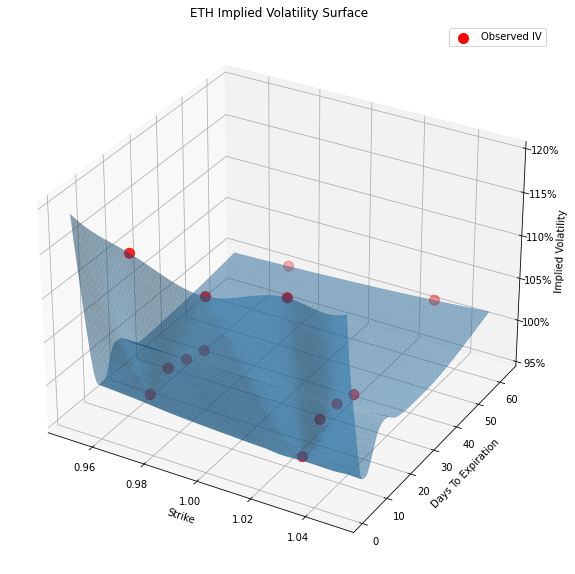

In [211]:

# Plot the implied volatility surface

option_data_ = option_data.iloc[1:].sort_values(['t','strike']).query('t>0')
x = (option_data['last_price'][0]/option_data_['strike'])
y = option_data_['t']
z = option_data_['mark_iv']/100

X,Y = np.meshgrid(np.linspace(.95,1.05,99),np.linspace(1,np.max(y),100))
Z = interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y), method='cubic')

xyz = pd.DataFrame({'x':x,'y':y,'z':z})
xyz = xyz.query('x>0.95 & x<1.05')
plot_iv_surf(X,Y,Z,xyz['x'],xyz['y'],xyz['z'],'Observed IV',instrument_name)

iv_df = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(.95,1.05,99))


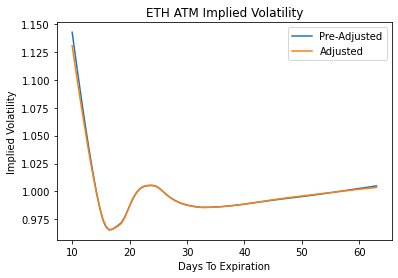

In [215]:
price_diff = option_data['mark_price'][0]-option_data['underlying_price']
option_data['iv_adj'] = option_data['mark_iv']+(option_data['greeks.delta']*price_diff)/(option_data['greeks.vega'])
option_data_ = option_data.iloc[1:].sort_values(['t','strike']).query('t>0')

Z = interpolate.griddata(np.array([x,y]).T,np.array(option_data_['iv_adj']/100),(X,Y), method='cubic')
iv_df_adj = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(.95,1.05,99))
iv_df.loc[:,1].plot(label='Pre-Adjusted')
(iv_df_adj.loc[:,1]).plot(label='Adjusted')
plt.xlabel('Days To Expiration')
plt.ylabel('Implied Volatility')
plt.legend()
plt.title(f'{instrument_name} ATM Implied Volatility')
plt.show()

# Hedging usando datos de Deribit

In [16]:
### Modelado de opciones con QuantLib

import numpy as np
import QuantLib as ql 
from QuantLib.QuantLib import nullInt
from pandas.core.base import DataError
from datetime import timedelta, datetime

def payoff(tipo, precio, base):
  if tipo == 'CALL':
    tipo_opcion = ql.Option.Call
  elif tipo == 'PUT':
    tipo_opcion = ql.Option.Put
  return ql.PlainVanillaPayoff(tipo_opcion, base)

def tasa_constante(fecha_valuacion, tasa_interes):
  return ql.YieldTermStructureHandle(ql.FlatForward(fecha_valuacion, 
                                                    tasa_interes, 
                                                    ql.Actual365Fixed()))

def get_valor_tasa(objeto_tasa, fecha_expiracion):
  return objeto_tasa.forwardRate(objeto_tasa.fecha_valuacion, 
                                 fecha_expiracion, 
                                 ql.Actual365Fixed(), 
                                 ql.Continuous).rate()

def volatilidad(fecha_valuacion, calendario, valor_volatilidad):
  return ql.BlackVolTermStructureHandle(
                          ql.BlackConstantVol(fecha_valuacion, 
                                              calendario, 
                                              valor_volatilidad, 
                                              ql.Actual365Fixed()
                                              )
                          )

def get_valor_volatilidad(objeto_volatilidad, fecha_expiracion, base):
  return objeto_volatilidad.blackVol(fecha_expiracion, base)

def proceso_BSM(precio_activo, fecha_valuacion, val_volatilidad, tasa_interes, 
                tasa_dividendos, calendario):
  ql.Settings.instance().evaluationDate = fecha_valuacion
  objeto_spot = ql.QuoteHandle(ql.SimpleQuote(precio_activo))
  objeto_tasa_interes = tasa_constante(fecha_valuacion, tasa_interes)
  objeto_tasa_dividendos = tasa_constante(fecha_valuacion, tasa_dividendos)
  objeto_volatilidad = volatilidad(fecha_valuacion, calendario, val_volatilidad)
  return ql.BlackScholesMertonProcess(objeto_spot, 
                                      objeto_tasa_dividendos, 
                                      objeto_tasa_interes, 
                                      objeto_volatilidad)

def precio_opcion_europea_BSM(tipo, precio, base, vencimiento, proceso_BSM):
  ejercicio_europeo = ql.EuropeanExercise(vencimiento)
  opcion_europea = ql.VanillaOption(payoff(tipo, precio, base), 
                                    ejercicio_europeo)
  opcion_europea.setPricingEngine(ql.AnalyticEuropeanEngine(proceso_BSM))
  return max(opcion_europea.NPV(),0)



ImportError: cannot import name 'DataError' from 'pandas.core.base' (/usr/local/lib/python3.8/dist-packages/pandas/core/base.py)

In [17]:
precio_activo = option_data["underlying_price"][1] # último precio registrado = precio Spot (S)
margen=0.6 # hedgeo alrededor de un % respecto del precio spot

epsilon=precio_activo*margen
K1=precio_activo-epsilon
K2=precio_activo+epsilon

print(precio_activo)
print(K1)
print(K2)


1640.3312
656.1324800000001
2624.52992


Como no necesariamente podemos encontrar put con strike a K1 y call con strike K2, construyamos funciones que encuentran strikes cercanos 

In [18]:
# Encuentra la coordenada de un vector más cercano a un valor
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def strike_put_near_k(K):
    vector_strike_puts = option_data[(option_data.callput=='P')]["strike"]
    return find_nearest(vector_strike_puts, K)

def strike_call_near_k(K):
    vector_strike_calls = option_data[(option_data.callput=='C')]["strike"]
    return find_nearest(vector_strike_calls, K)


# Si pedimos que el strike call>K2 y strike put< K1 
# vector_strike_calls = option_data[(option_data.callput=='C') & (option_data.strike >= K2)]["strike"]
# vector_strike_puts = option_data[(option_data.callput=='P') & (option_data.strike <= K1)]["strike"]


In [19]:
## 
nearK1 = strike_put_near_k(K1)
nearK2 = strike_call_near_k(K2)

print(K1)
print(nearK1)
print(K2)
print(nearK2)


656.1324800000001
1300.0
2624.52992
2200.0


In [20]:
option_data.columns

Index(['timestamp', 'state', 'settlement_price', 'open_interest', 'min_price',
       'max_price', 'mark_price', 'last_price', 'interest_value',
       'instrument_name', 'index_price', 'funding_8h',
       'estimated_delivery_price', 'current_funding', 'best_bid_price',
       'best_bid_amount', 'best_ask_price', 'best_ask_amount',
       'stats.volume_usd', 'stats.volume', 'stats.price_change', 'stats.low',
       'stats.high', 'underlying_price', 'underlying_index', 'mark_iv',
       'interest_rate', 'bid_iv', 'ask_iv', 'greeks.vega', 'greeks.theta',
       'greeks.rho', 'greeks.gamma', 'greeks.delta', 't', 'strike', 'callput',
       'm'],
      dtype='object')

In [21]:
option_data [option_data.strike == nearK1]["instrument_name"]

ETH-25FEB23-1300-P    ETH-25FEB23-1300-P
ETH-26FEB23-1300-P    ETH-26FEB23-1300-P
ETH-3MAR23-1300-P      ETH-3MAR23-1300-P
ETH-10MAR23-1300-P    ETH-10MAR23-1300-P
ETH-17MAR23-1300-P    ETH-17MAR23-1300-P
ETH-31MAR23-1300-P    ETH-31MAR23-1300-P
Name: instrument_name, dtype: object

In [23]:
from datetime import timedelta, datetime
valor_volatilidad = 0.3394  #Volatilidad Implicita anualizada (sigma)
tasa_interes = 0.0325 #tasa libre de riesgo anualizada (r) - tomo US02Y
tasa_dividendos =  0.0 #tasa de dividendos anualizada (q)

##Valuacion el 18 de julio de 2022
#fecha_valuacion = ql.Date(18, 7, 2022)
##Valuacion con fecha de hoy
fecha_valuacion = datetime.now()
fecha_valuacion = ql.Date(int(fecha_valuacion.strftime('%d')),
                            int(fecha_valuacion.strftime('%m')),
                            int(fecha_valuacion.strftime('%Y')))
#fecha_valuacion = ql.Date(28,7,2022)
##Expiracion el 16 de agosto de 2022
fecha_expiracion = ql.Date(28, 8, 2022)
# Mercado de USA
calendario = ql.UnitedStates()



In [24]:

print("Precios de opciones europeas de ETH evaluadas con fecha " +
      str(fecha_valuacion) +
      " sabiendo que: \n" +
      "\tprecio actual " + str(precio_activo) + "\n" +
      "\tvolatilidad " + str(valor_volatilidad) + "\n" +
      "\ttasa libre de riesgo "+ str(tasa_interes) + "\n" +
      "\ttasa dividendos "+ str(tasa_dividendos))

for (base, tipo) in (nearK1, 'PUT'), (nearK2, 'CALL'):
    print("Precio de opción europea " + str(tipo) + " strike " + 
            str(base) +" vencimiento "+ str(fecha_expiracion) +" según BSM: "+ 
            str(precio_opcion_europea_BSM(tipo, 
                                      precio_activo, 
                                      base, 
                                      fecha_expiracion,  
                                      proceso_BSM(precio_activo, 
                                                   fecha_valuacion, 
                                                   valor_volatilidad, 
                                                   tasa_interes, 
                                                   tasa_dividendos, 
                                                   calendario)
                                      )
               )
            )




Precios de opciones europeas de ETH evaluadas con fecha February 24th, 2023 sabiendo que: 
	precio actual 1640.3312
	volatilidad 0.3394
	tasa libre de riesgo 0.0325
	tasa dividendos 0.0


NameError: name 'precio_opcion_europea_BSM' is not defined

# Hedge mediante estrategia Strangle

In [25]:
precio_activo

1640.3312

In [26]:
def option_combination(P,K_call, K_put,d_call,d_put):
   call=0
   put=0
   for i in range(len(K_call)):
         call = call + max(P-K_call[i],0)
   for i in range(len(K_put)): 
         put = put + max(K_put[i]-P,0)  
   return call+put-sum (d_call)-sum(d_put)


In [27]:
def IL_P_usd(p,x_0,y_0, p_entry):
    V_hold = x_0 + y_0 * p
    return V_hold * (IL_R(p/p_entry))


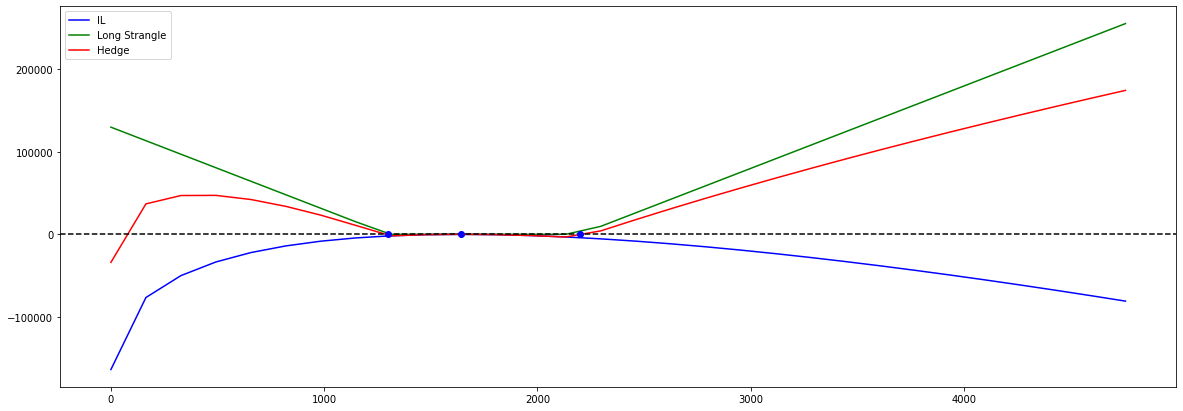

In [28]:

balance_usdc = precio_activo*100 #x_0
balance_eth = 100 #y_0

precio_activo = balance_usdc / balance_eth #P_0
V_h_0= balance_usdc+balance_eth*precio_activo # valor en dólares de las tenencias iniciales

price_change = np.arange(-1, 2, 0.1)


r_p = 0.02  # radio mensual por proveer liquidez
P = precio_activo*(1+ price_change)

ret_mens_pool=r_p* V_h_0 # ¿sobre las tenencias inicial?

  
K_put =  nearK1*np.ones(100)
K_call =  nearK2*np.ones(100)
d_call = 0*np.ones(100)
d_put = 0*np.ones(100)

opt_stg = [option_combination(p,K_call,K_put,d_call,d_put) for p in P] 


IL_sin_hedg_usd = [IL_P_usd(p, balance_usdc, balance_eth, precio_activo) for p in P]
IL_con_hedg_usd = r_p*np.ones(len(P)) + IL_sin_hedg_usd + opt_stg


fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(P, IL_sin_hedg_usd, c = 'blue', label = 'IL')
axs.plot(P, opt_stg, c = 'green', label = 'Long Strangle' )
axs.plot(P, IL_con_hedg_usd, c = 'red', label = 'Hedge')
axs.legend()
axs.axhline(y = 0, color = 'black', linestyle = '--')
plt.plot(precio_activo, 0, 'bo')
plt.plot(nearK1, 0, 'bo')
plt.plot(nearK2, 0, 'bo')
plt.show()